In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import lil_matrix

In [ ]:
# 1. Класс генератора слов (алфавит, н-граммы)
# 2. Класс н-грамм
# 3. Класс подсчёта перплексий (?)
# 4. Статистический класс (?)
# 5. Класс обучения и выполнения модели (не только регрессия, но и остальные модели)
# 6. Класс перплексий

# Мб использовать стороннюю библиотеку для токенизации (создания n-грамм)
# Сторонняя библиотека для тестов (PyTest)
# Мб применить ради интереса нейросеть (или написать модуль обучения просто)

In [2]:
from abc import abstractmethod

In [3]:
import unittest

In [ ]:
# Можно протестить тестами всякие соответствия типов

In [4]:
class SpecificTypeError(TypeError):
  def __init__(self, real_type, expected_type):
    message = f'{expected_type} expected instead of {real_type}'
    super().__init__(message)

In [5]:
class EmptyError(ValueError):
  def __init__(self, type_object):
    message = f'{type_object} is empty'
    super().__init__(message)

In [21]:
# Есть какой-то алфавит
# Есть метод генерации слов

class WordGenerator:
  _words = []

  def __init__(self, words):
    if not isinstance(words, list):
      raise SpecificTypeError(type(words).__name__, list.__name__)
    self._words = words
  
  @abstractmethod
  def generate_word(self):
    pass

In [22]:
from collections import Counter
from random import randint

class RandomAlphabetGenerator(WordGenerator):
  _alphabet = []
  _max_len = -1
  _min_len = -1

  def __init__(self, words, min_len, max_len):
    WordGenerator.__init__(self, words)
    if not isinstance(min_len, int):
      raise SpecificTypeError(type(min_len).__name__, int.__name__)
    if not isinstance(max_len, int):
      raise SpecificTypeError(type(max_len).__name__, int.__name__)
    self._min_len = min_len
    self._max_len = max_len

  def make_alphabet(self):
    self._alphabet = []

    for word in self._words:
      self._alphabet.extend([letter.lower() for letter in word])

    self._alphabet = list(Counter(self._alphabet).keys())
  
  def generate_word(self):
    if len(self._alphabet) == 0:
      raise EmptyError(type(self._alphabet).__name__)

    letters_list = []

    rand_len = randint(self._min_len, self._max_len)

    for i in range(rand_len):
      rand_letter = randint(0, len(self._alphabet) - 1)
      letters_list.append(self._alphabet[rand_letter])

    return ''.join(letters_list)

In [23]:
class Matrix:
  __matrix = lil_matrix

  def __init__(self, matrix):
    if not isinstance(matrix, lil_matrix):
      raise SpecificTypeError(type(matrix).__name__, lil_matrix.__name__)
    self.__matrix = matrix

  def __getitem__(self, row):
    return self.__matrix.getrow(row).toarray()

In [9]:
# Протестить корректность составления n-gram

class Ngrammer:

  @staticmethod
  def make_ngram(tokens, n):
    if n <= 0:
      raise EmptyError("n")
    ngrams = []
    for i in range(0, len(tokens) - n + 1):
        ngrams.append(' '.join(tokens[i:i + n]))

    return ngrams

In [24]:
class TestCase:
  _expected_result = any

  @property
  def get_expected_result(self):
    return self._expected_result

  def __init__(self, expected_result):
    self._expected_result = expected_result

In [25]:
class NgrammerTest(unittest.TestCase):
  class NgrammerTestCase(TestCase):

    __tokens = list
    __n = int

    @property
    def get_tokens(self):
      return self.__tokens

    @property
    def get_n(self):
      return self.__n

    def __init__(self, tokens, n, expected_result):
      self.__tokens = tokens
      self.__n = n
      TestCase.__init__(self, expected_result)

  def setUp(self):
    tokens = ['Съешь', 'этих', 'мягких', 'французских', 'булочек']
    self.test_cases = [
                self.NgrammerTestCase(tokens, 0, EmptyError),
                self.NgrammerTestCase(tokens, 1, ['Съешь', 'этих', 'мягких', 'французских', 'булочек']),
                self.NgrammerTestCase(tokens, 3, ['Съешь этих мягких', 'этих мягких французских', 'мягких французских булочек']),
                self.NgrammerTestCase(tokens, 5, ['Съешь этих мягких французских булочек']),
                self.NgrammerTestCase(tokens, 10, []),     
    ]

  def testNgrammerMake_ngram(self):
    for test_case in self.test_cases:
      if test_case.get_expected_result is EmptyError:
        with self.assertRaises(test_case.get_expected_result):
          self.__call_ngrammer(test_case)
      else:
        self.__call_ngrammer(test_case)

  def __call_ngrammer(self, test_case):
    tokens, n = test_case.get_tokens, test_case.get_n
    Ngrammer.make_ngram(tokens, n)

In [28]:
class AbstractNgramModel:
  _n = int
  _words = list
  _matrix = Matrix
  _rows = list
  _cols = list
  _rows_id = dict
  _cols_id = dict
  _ngrams = list

  @property
  def get_matrix(self):
    return self._matrix

  @property
  def get_rows(self):
    return self._rows

  @property
  def get_cols(self):
    return self._cols

  @property
  def get_rows_id(self):
    return self._rows_id

  @property
  def get_cols_id(self):
    return self._cols_id

  @property
  def get_ngrams(self):
    return self._ngrams

  def __init__(self, n, words):
    if not isinstance(words, list):
      raise SpecificTypeError(type(words).__name__, list.__name__)
    self._n = n
    self._words = words

  def _make_ngrams(self, tokens, n):
    return Ngrammer.make_ngram(tokens, n)

  @abstractmethod
  def make_model(self):
    pass

In [13]:
class NgramModelCreator:
  __n = -1
  __words = list

  def __init__(self, n, words):
    if not isinstance(n, int):
      raise SpecificTypeError(type(n).__name__, int.__name__)
    if not isinstance(words, list):
      raise SpecificTypeError(type(words).__name__, list.__name__)
    if n <= 0:
      raise EmptyError("n")
    if len(words) == 0:
      raise EmptyError(type(words).__name__)
    self.__n = n
    self.__words = words

  @property
  def get_model(self) -> AbstractNgramModel:
    if self.__n == 1:
      return UnigramModel(self.__n, self.__words)
    else:
      return NgramModel(self.__n, self.__words)

In [29]:
class NgramModelCreatorTest(unittest.TestCase):
  class NgramModelCreatorTestCase(TestCase):

    __n = int
    __words = list

    @property
    def get_n(self):
      return self.__n

    @property
    def get_words(self):
      return self.__words

    def __init__(self, n, words, expected_result):
      self.__n = n
      self.__words = words
      TestCase.__init__(self, expected_result)

  def setUp(self):
    self.init_test_cases = [
                  self.NgramModelCreatorTestCase("abc", ['a'], SpecificTypeError),
                  self.NgramModelCreatorTestCase(1, "abc", SpecificTypeError),
                  self.NgramModelCreatorTestCase(-1, ['a'], EmptyError),
                  self.NgramModelCreatorTestCase(10, [], EmptyError),
    ]
    self.get_model_test_cases = [
                                  self.NgramModelCreatorTestCase(1, ['a'], UnigramModel),
                                  self.NgramModelCreatorTestCase(10, ['b'], NgramModel),
    ]

  def testInitNgramModelCreator(self):
    for test_case in self.init_test_cases:
      with self.assertRaises(test_case.get_expected_result):
          NgramModelCreator(test_case.get_n, test_case.get_words)

  def testGet_modelNgramModelCreator(self):
    for test_case in self.get_model_test_cases:
      self.assertIsInstance(NgramModelCreator(test_case.get_n, test_case.get_words).get_model, test_case.get_expected_result)

In [31]:
class UnigramModel(AbstractNgramModel):

  def __init__(self, n, words):
    AbstractNgramModel.__init__(self, n, words)

  def make_model(self):
    raise NotImplementedError()

In [33]:
class NgramWordGenerator(WordGenerator):
  _ngrams = AbstractNgramModel

  @property
  def get_ngrams(self):
    return self._ngrams

  @get_ngrams.setter
  def set_ngrams(self, value):
    if not isinstance(value, AbstractNgramModel):
      raise SpecificTypeError(type(value).__name__, AbstractNgramModel.__name__)
    self._ngrams = value

  def __init__(self, words, ngrams):
    WordGenerator.__init__(self, words)
    if not isinstance(ngrams, AbstractNgramModel):
      raise SpecificTypeError(type(ngrams).__name__, AbstractNgramModel.__name__)
    self._ngrams = ngrams

  def generate_word(self):
    word = []
    start_words = ['<start>'] * (len(self._ngrams.get_ngrams()) - 1)
    rows = self._ngrams.get_rows()
    cols = self._ngrams.get_cols()
    rows_id = self._ngrams.get_rows_id()
    matrix = self._get_matrix()
    current_idx = rows_id[start_words]
    while True:
        chosen = np.random.choice(matrix[current_idx].shape[1], p=matrix[current_idx].toarray()[0])
        word.append(cols[chosen])
        if cols[chosen] == '<end>':
            return ''.join(word)

In [34]:
# Проверить корректность вычисления перплексии

class PerplexityMetric:
  __words = list
  __ngrams = list
  __n = int

  def __init__(self, words, ngrams):
    if not isinstance(words, list):
      raise SpecificTypeError(type(words).__name__, list.__name__)
    if not isinstance(ngrams, list):
      raise SpecificTypeError(type(ngrams).__name__, list.__name__)
    self.__words = words
    self.__ngrams = ngrams
    self.__n = len(self.__ngrams)

  def __perplexity(self, probas):
    p = np.exp(np.sum(probas))
    N = len(probas)

    return p**(-1/N)

  def compute_perplexity(self):
    perplexities = []

    for word in self.__words:
      if len(word) <= self.__n-1:
        perplexities.append(np.mean(perplexities + [1]))
        continue

      prob = []
      
      for ngram in Ngrammer.make_ngram(word, n=self.__n):
          phrase = ngram.split()

          if ngram in self.__ngrams[-1]:
              if self.__n == 1:
                prob.append(np.log(self.__ngrams[0][ngram]/self.__ngrams[0][phrase[0]]))
              else:
                prob.append(np.log(self.__ngrams[-1][ngram]/self.__ngrams[self.__n-2][' '.join(phrase[:self.__n-1])]))
          else:
              prob.append(np.log(0.00001))
      
      perplexities.append(self.__perplexity(prob))

    return perplexities

In [35]:
# Мб проверить статистические штуки у нграм

class NgramModel(AbstractNgramModel):

  def __init__(self, n, words):
    AbstractNgramModel.__init__(self, n, words)

  def make_model(self):
    self._ngrams = [Counter() for i in range(self._n)]

    self._ngrams = self.__generate_ngrams_list(self._ngrams, self._n)

    self._rows = list(self._ngrams[-2])
    self._rows_id = {gram: i for i, gram in enumerate(self._rows)}
    self._cols = list(self._ngrams[0])
    self._cols_id = {word: i for i, word in enumerate(self._cols)}

    self._matrix = self.__fill_matrix(self._n)

  def __generate_ngrams_list(self, ngrams, n):
    for word in self._words:
      ngrams[0].update(word)
      for i in range(2, n+1):
        ngrams[i-1].update(self._make_ngrams(word, n=i))

    return ngrams

  def __fill_matrix(self, n):
    all_matrix = lil_matrix((len(self._ngrams[-2]), 
                         len(self._ngrams[0])),)

    for ngram in self._ngrams[-1]:

        phrase = ngram.split()

        all_matrix[self._rows_id[' '.join(phrase[:n-1])], self._cols_id[phrase[-1]]] =  (self._ngrams[n-1][ngram]/
                                                                        self._ngrams[n-2][' '.join(phrase[:n-1])])
    
    return Matrix(all_matrix)

In [36]:
unittest.main(argv=[''], verbosity=2, exit=False)

testGet_modelNgramModelCreator (__main__.NgramModelCreatorTest) ... ok
testInitNgramModelCreator (__main__.NgramModelCreatorTest) ... ok
testNgrammerMake_ngram (__main__.NgrammerTest) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.010s

OK


In [37]:
df = pd.read_json('borrowings.json', encoding='utf-8')

In [38]:
df = df[~df['ipa'].isnull()]
df = df[~df['glottocode'].isnull()]
df = df[~df['glottocode'].str.contains('toki')]

In [ ]:
# Проверить корректность реплейсера

class Preprocessor:
  __words = list

  @property
  def get_words(self):
    return self.__words

  def __init__(self, words):
    self.__words = words

  def replace_spaces(self, replacer='#'):
    self.__words = list(map(lambda x: x.replace(' ', replacer), self.__words))
    return self

In [99]:
class AbstractPreprocessingBuilder:

  _n = int
  _result = any

  @property
  def result(self):
    return self._result

  @property
  def words(self):
    pass

  @words.setter
  def words(self, words):
    pass

  @property
  def n(self):
    return self._n

  @n.setter
  def n(self, value):
    if not isinstance(value, int):
      raise SpecificTypeError(type(value).__name__, int.__name__)
    self._n = value

  def __init__(self):
    self._result = None

  @abstractmethod
  def build(self):
    pass

In [107]:
class SeriePreprocessingBuilder(AbstractPreprocessingBuilder):

  __serie = pd.Series

  @property
  def words(self):
    return self.__serie

  @words.setter
  def words(self, words):
    if not isinstance(words, pd.Series):
      SpecificTypeError(type(words).__name__, pd.Series.__name__)
    self.__serie = words.copy()

  def __init__(self):
    super().__init__()

  def build(self):
    self._result = self.__serie.apply(self.__convert_to_list()).apply(self.__replace_spaces()).apply(self.__add_pseudo_words())
  
  def __convert_to_list(self):
    return lambda x: [x] if not isinstance(x, list) else x
  
  def __replace_spaces(self):
    return lambda x: ['#' if letter in ['', ' '] else letter for letter in x]

  def __add_pseudo_words(self):
    return lambda x: ['<start>'] * (self._n - 1) + x + ['<end>']

In [113]:
class PreprocessingDirector:

  __builder = AbstractPreprocessingBuilder

  def __init__(self):
    self.__builder = None

  @property
  def builder(self):
    return self.__builder
  
  @builder.setter
  def builder(self, builder):
    self.__builder = builder

  def build(self, words, n):
    self.__builder.words = words
    self.__builder.n = n
    self.__builder.build()
    return self

In [144]:
class FilterDataFrame:

  __condition = str
  __serie = pd.Series

  def __init__(self, condition, serie):
    self.__condition = condition
    self.__serie = serie

  def filter_result(self):
      conditions = {
        'EQUAL_1': self.__serie == 1,
        'EQUAL_0': self.__serie == 0,
        'IS_NULL': ~self.__serie.isnull(),
        'NOT_IS_NULL': self.__serie.isnull()
        }

      return conditions[self.__condition]

In [145]:
class DfPerplexityCreator:
    __df = pd.DataFrame

    def __init__(self, origin_df, lang_column, language):
      self.__df = origin_df[origin_df[lang_column] == language]

    def get_perplexity_column(self, n, words_column, target_column, condition, director):
      mask = FilterDataFrame(condition, self.__df[target_column]).filter_result()
      words_serie = director.build(self.__df[mask][words_column], n).builder.result

      all_words = director.build(self.__df[words_column], n).builder.result
      model = NgramModelCreator(n, list(all_words)).get_model
      model.make_model()
      metric = PerplexityMetric(list(words_serie), model.get_ngrams)
      words_serie = pd.Series(metric.compute_perplexity(), index=words_serie.index)
      return words_serie

In [146]:
perps_df = df[['glottocode', 'ipa', 'segments', 'bor']]
director = PreprocessingDirector()
director.builder = SeriePreprocessingBuilder()
for i in range(2, 5):
  series = pd.Series()
  for language in perps_df['glottocode'].unique():
    print(language)
    df_creator = DfPerplexityCreator(perps_df, 'glottocode', language)
    series = series.append(df_creator.get_perplexity_column(i, 'segments', 'bor', 'EQUAL_1', director))
    series = series.append(df_creator.get_perplexity_column(i, 'segments', 'bor', 'EQUAL_0', director))
  perps_df[f'{i}_gram'] = series

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


bagv1239
kara1474
akhv1239
botl1242
andi1255
ghod1238
cham1309
tind1238


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


bagv1239
kara1474
akhv1239
botl1242
andi1255
ghod1238
cham1309
tind1238
bagv1239
kara1474
akhv1239
botl1242
andi1255
ghod1238
cham1309
tind1238


In [147]:
perps_df

,glottocode,ipa,segments,bor,2_gram,3_gram,4_gram
0,bagv1239,'i-n-ʃː-u-l-a-d-a,"['i, n, ʃː, u, l, a, d, a]",0,11.488608,13.961940,6.574148
1,bagv1239,ĩ-ʃː-'u-r-d-a,"[ĩ, ʃː, 'u, r, d, a]",0,15.189713,9.531430,5.747935
2,kara1474,tɬ-'u-r-i-χ-b-i,"[tɬ, 'u, r, i, χ, b, i]",0,21.232125,15.463698,5.547998
3,kara1474,r-i-s-'i-d-o-b-o,"[r, i, s, 'i, d, o, b, o]",0,15.910206,9.677443,3.393909
4,kara1474,w-a-s-i-n-j-a-s-'i-n-tʃ'-a-r-i-ʕ-'a,"[w, a, s, i, n, j, a, s, 'i, n, tʃ', a, r, i, ...",0,26.935577,11.575967,3.410712
...,...,...,...,...,...,...,...
88315,tind1238,'a-q'-i-l-u,"['a, q', i, l, u]",0,28.237522,18.235921,7.981679
88316,tind1238,a-tɬ'-u-w-'u-b,"[a, tɬ', u, w, 'u, b]",0,23.120417,8.904182,6.351525
88317,tind1238,h-u-n-'aː-j-ɬʲ-a,"[h, u, n, 'aː, j, ɬʲ, a]",0,6.997997,4.735314,3.134941
88318,tind1238,χːʷ-ãː-j,"[χːʷ, ãː, j]",0,17.220037,13.379291,11.160386


In [148]:
perps_df.describe()

,bor,2_gram,3_gram,4_gram
count,87777.000000,87777.000000,87777.000000,87777.000000
mean,0.110553,15.733201,8.808225,5.098194
std,0.313579,10.286610,4.975240,2.895556
min,0.000000,3.466707,2.071214,1.772442
25%,0.000000,9.791486,5.384506,3.440817
50%,0.000000,13.448146,7.820181,4.489928
75%,0.000000,18.677621,10.886439,5.980799
max,1.000000,514.825721,140.260472,140.260472


In [149]:
perps_df.mad()

bor       0.196662
2_gram    6.365217
3_gram    3.511502
4_gram    1.740532
dtype: float64

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

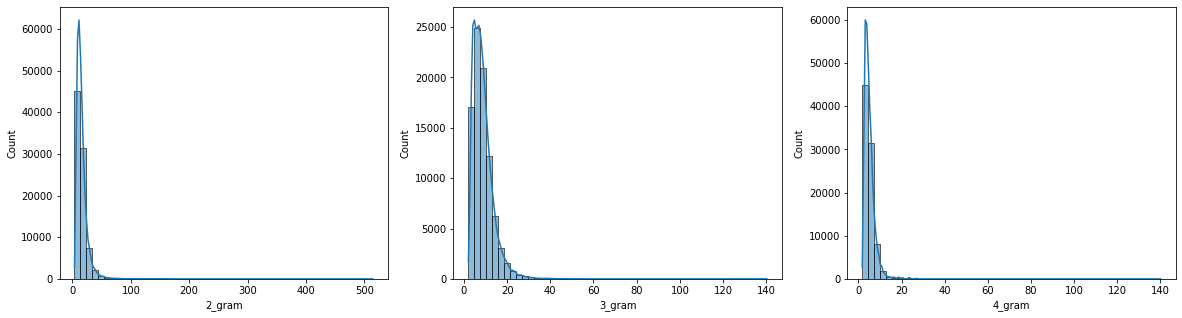

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
sns.histplot(perps_df['2_gram'], bins=50, ax=axes[0], kde=True);
sns.histplot(perps_df['3_gram'], bins=50, ax=axes[1], kde=True);
sns.histplot(perps_df['4_gram'], bins=50, ax=axes[2], kde=True);

In [152]:
perps_df['2_gram_log'] = np.log(perps_df['2_gram'])
perps_df['3_gram_log'] = np.log(perps_df['3_gram'])
perps_df['4_gram_log'] = np.log(perps_df['4_gram'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


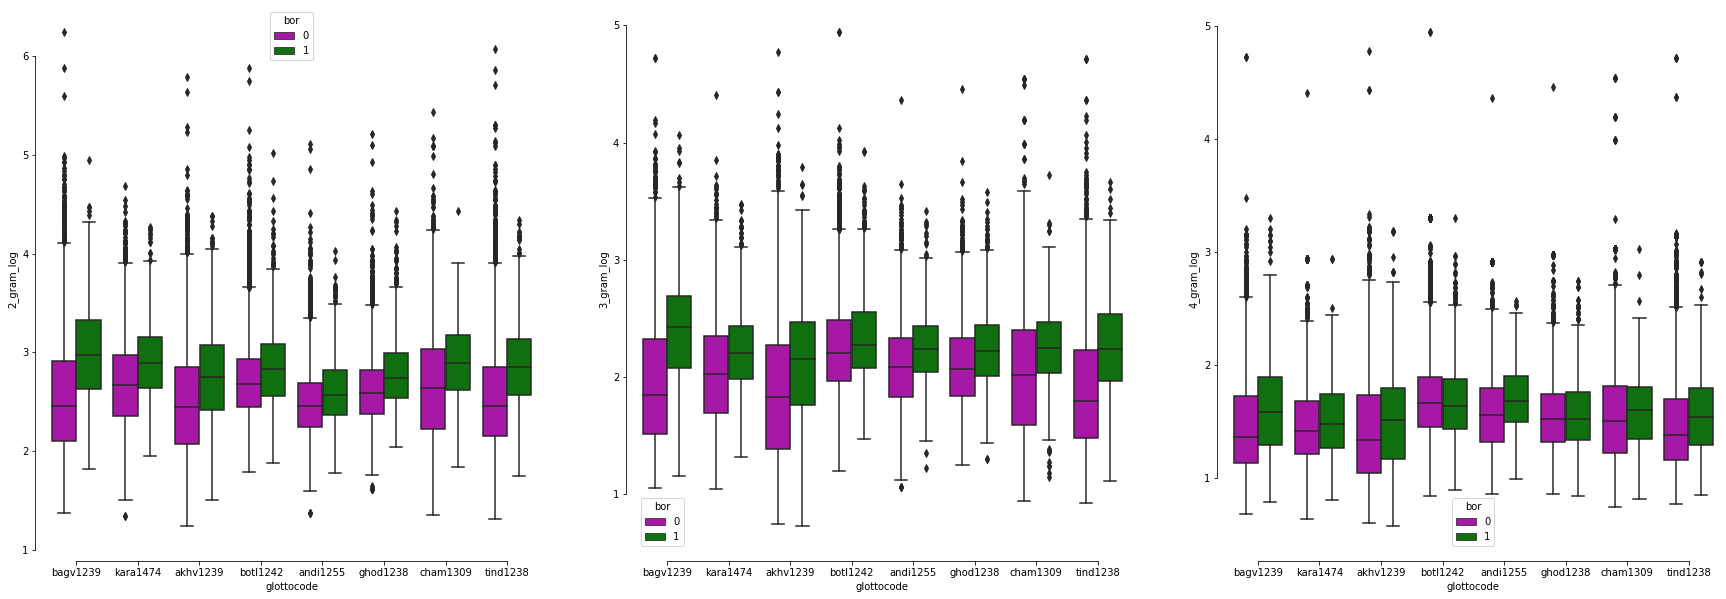

In [153]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
sns.boxplot(x="glottocode", y="2_gram_log",
            palette=["m", "g"], hue='bor',
            data=perps_df, ax=axes[0]);
sns.boxplot(x="glottocode", y="3_gram_log",
            palette=["m", "g"], hue='bor',
            data=perps_df, ax=axes[1]);
sns.boxplot(x="glottocode", y="4_gram_log",
            palette=["m", "g"], hue='bor',
            data=perps_df, ax=axes[2]);

sns.despine(offset=10, trim=True)

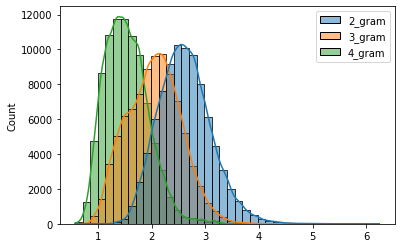

In [154]:
sns.histplot(np.log(perps_df[['2_gram', '3_gram', '4_gram']]), bins=40, kde=True);

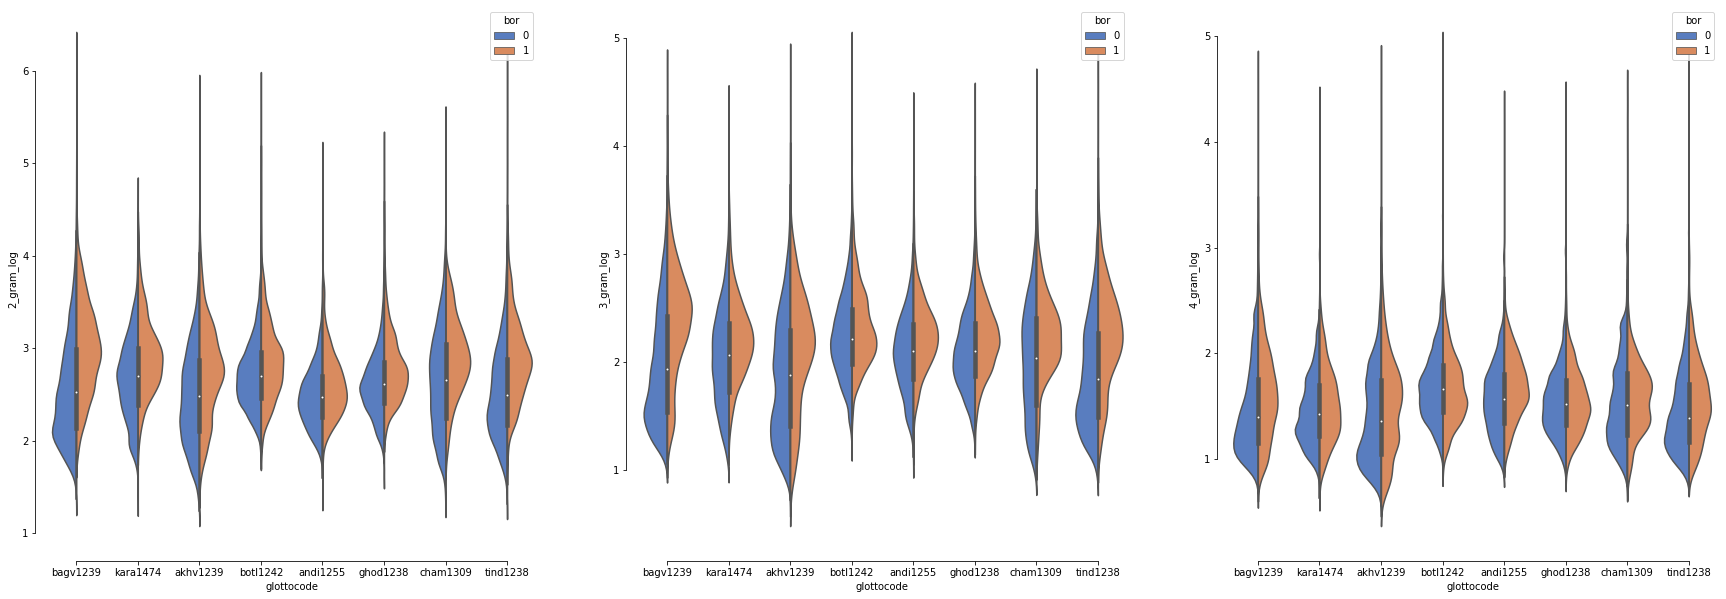

In [155]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
sns.violinplot(x="glottocode", y="2_gram_log", hue="bor",
                    data=perps_df, palette="muted", split=True, ax=axes[0]);
sns.violinplot(x="glottocode", y="3_gram_log", hue="bor",
                    data=perps_df, palette="muted", split=True, ax=axes[1]);
sns.violinplot(x="glottocode", y="4_gram_log", hue="bor",
                    data=perps_df, palette="muted", split=True, ax=axes[2]);

sns.despine(offset=10, trim=True)